<a href="https://colab.research.google.com/github/saritmaitra/Segmentation-Clustering/blob/master/CLTV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Customer Lifetime Value(CLTV)
"Customer Lifetime Value is a monetary value that represents the amount of revenue or profit a customer will give the company over the period of the relationship" (Source). CLTV demonstrates the implications of acquiring long-term customers compare to short-term customers. Customer lifetime value (CLV) can help us to answers the most important questions about sales to every company: 
- How to Identify the most profitable customers?
- How can a company offer the best product and make the most money?
- How to segment profitable customers?
- How much budget need to spend to acquire customers?
##Calculate Customer Lifetime Value
There are lots of approaches available for calculating CLTV. Everyone has their own view on it. 
- We can compute it by adding profit/revenue from customers in a given cycle. For Example, if the customer is associated with the business for the last 3 years, we can sum all the profit in this 3 years. We can average the profit yearly or half-yearly or monthly, but in this approach, we won's be able to build a predictive model for new customers.
- Build a regression model for existing customers. Take recent six-month data as independent variables and total revenue over three years as a dependent variable and build a regression model on this data.
- CLTV can also implement using RFM(Recency, Frequency, Monetary) values. For more details, you can refer to my tutorial.
- Using the following equation: CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.
    -  Customer Value = Average Order Value * Purchase Frequency
    - Average Order Value(AOV) = Total Revenue / Total Number of Orders. AOV represents the mean amount of revenue that the customer spends on an order.
    - Purchase Frequency =  Total Number of Orders / Total Number of Customers. It represents the average number of orders placed by each customer.
    - Churn Rate: Churn Rate is the percentage of customers who have not ordered again.
    - Customer Lifetime = 1/ churn rate
    - Churn Rate= 1-Repeat Rate

In [0]:
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Online Retail.xlsx to Online Retail.xlsx


In [3]:
data = pd.read_excel("Online Retail.xlsx")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Removing Duplicates
Sometimes we get a messy dataset. we may have to deal with duplicates, which will skew your analysis. 

In [0]:
filtered_data=data[['Country','CustomerID']].drop_duplicates()

Let's Jump into Data Insights

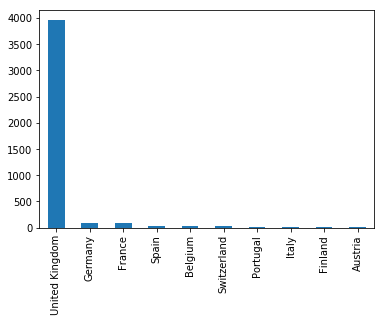

In [5]:
#Top ten country's customer
filtered_data.Country.value_counts()[:10].plot(kind='bar')
plt.show()

In the given dataset, we can observe most of the customers are from "United Kingdom". So, we can filter data for United Kingdom customer.

In [6]:
uk_data=data[data.Country=='United Kingdom']
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      495478 non-null object
StockCode      495478 non-null object
Description    494024 non-null object
Quantity       495478 non-null int64
InvoiceDate    495478 non-null datetime64[ns]
UnitPrice      495478 non-null float64
CustomerID     361878 non-null float64
Country        495478 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.0+ MB


#### Descriptive statistic

In [7]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


Here, we can observe some of the customers have ordered in a negative quantity, which is not possible. So, we need to filter Quantity greater than zero.

In [8]:
uk_data = uk_data[(uk_data['Quantity']>0)]
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486286 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      486286 non-null object
StockCode      486286 non-null object
Description    485694 non-null object
Quantity       486286 non-null int64
InvoiceDate    486286 non-null datetime64[ns]
UnitPrice      486286 non-null float64
CustomerID     354345 non-null float64
Country        486286 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.4+ MB


#### Filter required Columns
Here, we can filter the necessary columns for calculating CLTV. We only need here five columns CustomerID, InvoiceDate, InvoiceNo, Quantity, and UnitPrice.
 - CustomerID will uniquely define our customers.
 - InvoiceDate help us calculate numbers of days customer stayed with your product.
 - InvoiceNo helps us to count the number of time transaction performed(frequency).
 - Quantity is purchased item units in each transaction
 - UnitPrice of each unit purchased by the customer will help us to calculate the total purchased amount.

In [0]:
uk_data=uk_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]

#Calulate total purchase
uk_data['TotalPurchase'] = uk_data['Quantity'] * uk_data['UnitPrice']

Here, we are going to perform the following operations:
- Calculate the number of days between the present date and the date of last purchase from each customer.
- Calculate the number of orders for each customer.
- Calculate sum of purchase price for each customer.

In [10]:
uk_data_group=uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalPurchase': lambda price: price.sum()})

uk_data_group.head()

,InvoiceDate,InvoiceNo,Quantity,TotalPurchase
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4596,25748,33719.73
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


Renaming the column

In [11]:
# Change the name of columns
uk_data_group.columns=['num_days','num_transactions','num_units','spent_money']
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4596,25748,33719.73
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


## Calculate CLTV using following formula:
CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

Customer Value = Average Order Value * Purchase Frequency

In [12]:
# Average Order Value
uk_data_group['avg_order_value']=uk_data_group['spent_money']/uk_data_group['num_transactions']
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value
CustomerID,,,,,
12346.0,0,1,74215,77183.60,77183.600000
12747.0,366,103,1275,4196.01,40.737961
12748.0,372,4596,25748,33719.73,7.336756
12749.0,209,199,1471,4090.88,20.557186
12820.0,323,59,722,942.34,15.971864


##  Calculate Purchase Frequency

In [0]:
purchase_frequency=sum(uk_data_group['num_transactions'])/uk_data_group.shape[0]

## Calculate Repeat Rate and Churn Rate

In [14]:
# Repeat Rate
repeat_rate=uk_data_group[uk_data_group.num_transactions > 1].shape[0]/uk_data_group.shape[0]
#Churn Rate
churn_rate=1-repeat_rate
purchase_frequency,repeat_rate,churn_rate

(90.37107880642694, 0.9818923743942872, 0.018107625605712774)

## Calculate Profit Margin
Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain. Let's assume our business has approx 5% profit on the total sale.

In [15]:
# Profit Margin
uk_data_group['profit_margin']=uk_data_group['spent_money']*0.05
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
CustomerID,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800
12747.0,366,103,1275,4196.01,40.737961,209.8005
12748.0,372,4596,25748,33719.73,7.336756,1685.9865
12749.0,209,199,1471,4090.88,20.557186,204.5440
12820.0,323,59,722,942.34,15.971864,47.1170


## Calcualte Customer Lifetime Value

In [16]:
# Customer Value
uk_data_group['CLV']=(uk_data_group['avg_order_value']*purchase_frequency)/churn_rate

#Customer Lifetime Value
uk_data_group['cust_lifetime_value']=uk_data_group['CLV']*uk_data_group['profit_margin']

uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
CustomerID,,,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800,3.852060e+08,1.486579e+12
12747.0,366,103,1275,4196.01,40.737961,209.8005,2.033140e+05,4.265538e+07
12748.0,372,4596,25748,33719.73,7.336756,1685.9865,3.661610e+04,6.173424e+07
12749.0,209,199,1471,4090.88,20.557186,204.5440,1.025963e+05,2.098545e+07
12820.0,323,59,722,942.34,15.971864,47.1170,7.971198e+04,3.755789e+06


# Prediction Model for CLTV
Let's build the CLTV prediction model. 
Here, we are going to predict CLTV using Linear Regression Model.
Let's first use the data loaded and filtered above.

In [17]:
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


Extract month and year from InvoiceDate.

In [18]:
uk_data['month_yr'] = uk_data['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase,month_yr
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30,Dec-2010
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00,Dec-2010
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010


The pivot table takes the columns as input, and groups the entries into a two-dimensional table in such a way that provides a multidimensional summarization of the data.

In [19]:
sale=uk_data.pivot_table(index=['CustomerID'],columns=['month_yr'],values='TotalPurchase',aggfunc='sum',fill_value=0).reset_index()
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00
2,12748.0,1100.37,898.24,4228.13,1070.27,389.64,418.77,1113.27,2006.26,1179.37,2234.50,10639.23,2292.84,6148.84
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77


Let's sum all the months sales.

In [20]:
sale['CLV']=sale.iloc[:,2:].sum(axis=1)
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,77183.60
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00,4196.01
2,12748.0,1100.37,898.24,4228.13,1070.27,389.64,418.77,1113.27,2006.26,1179.37,2234.50,10639.23,2292.84,6148.84,32619.36
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00,4090.88
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77,942.34


### Selecting Feature
Here, we need to divide the given columns into two types of variables dependent(or target variable) and independent variable(or feature variables). Select latest 6 month as independent variable.

In [0]:
X=sale[['Dec-2011','Nov-2011', 'Oct-2011','Sep-2011','Aug-2011','Jul-2011']]
y=sale[['CLV']]

### Splitting Data
To understand model performance, dividing the dataset into a training set and a test set is a good strategy.

We need to pass 3 parameters features, target, and test_set size. Additionally, we can use random_state as a seed value to maintain reproducibility, which means whenever we split the data will not affect the results. Also, if random_state is None, then random number generator uses np.random for selecting records randomly. It means if we don't set a seed, it is different each time.

In [0]:
#split training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [23]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

[208.50969617]
[[0.99880551 0.80381254 1.60226829 1.67433228 1.52860813 2.87959449]]


### Model Fit 
In order to evaluate the overall fit of the linear model, we use the R-squared value. R-squared is the proportion of variance explained by the model. Value of R-squared lies between 0 and 1. Higher value or R-squared is considered better because it indicates the larger variance explained by the model.

In [24]:
from sklearn import metrics

# compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))

R-Square: 0.9666074402817513


This model has a higher R-squared (0.96). This model provides a better fit to the data.
Model Evaluation
For regression problems following evaluation metrics used:
- Mean Absolute Error (MAE) is the mean of the absolute value of the errors.
- Mean Squared Error (MSE) is the mean of the squared errors.
- Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors.

In [0]:
# calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))

# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 595.0282284701232
MSE 2114139.8898678916
RMSE: 1454.008215199588


RMSE is more popular than MSE and MAE because RMSE is interpretable with y because of the same units.

# Pros and Cons of CLTV
- CLTV helps us to design an effective business plan and also provide a chance to scale our business.
- CLTV draw meaningful customer segments these segment can help us to identify needs of the different-different segment. 
- CLTV can figure out most profitable customers, but how we are going to make a profit from them, it depends on our strategy. 
Generally, CLTV models are confused and misused. Obsession with CLTV may create blunders. Companies only focus on finding the best customer group and focusing on them and repeat the business, but it’s also important to give attention to other customers.

# CLTV Model Definition
For the CLTV models, the following nomenclature is used:
- Frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.
- T represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

We have some cleaning to do, then create a new dataframe that contains CustomerID, InvoiceDate (remove the time) and add a new column — sales:

In [25]:
import datetime as dt
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.date
data = data[pd.notnull(data['CustomerID'])]
data = data[(data['Quantity']>0)]
data['Sales'] = data['Quantity'] * data['UnitPrice']
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
data = data[cols_of_interest]
print(data.head())
print(data['CustomerID'].nunique())

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
4339


In [26]:
pip install lifetimes

     |████████████████████████████████| 583kB 2.6MB/s 


In [27]:
from lifetimes.plotting import *
from lifetimes.utils import *

df = summary_data_from_transaction_data(data, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
df.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


There are 4339 customers under our analysis.
CustomerID 12346 made 1 purchase only (no repeat), so the frequency and recency are 0, and the age is 325 days (e.g. the duration between the first purchase and the end of the period in the analysis).

count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.0038927031292407595


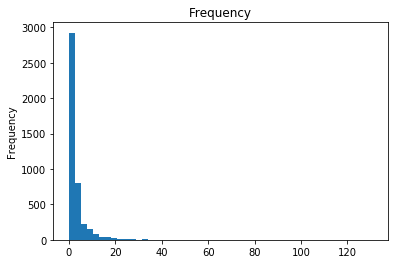

In [28]:
df['frequency'].plot(kind='hist', bins=50)
plt.title('Frequency')
print(df['frequency'].describe())
print(sum(df['frequency'] == 0)/float(len(data)))

count    4339.000000
mean      130.741415
std       132.210176
min         0.000000
25%         0.000000
50%        93.000000
75%       252.000000
max       373.000000
Name: recency, dtype: float64
0.0038927031292407595


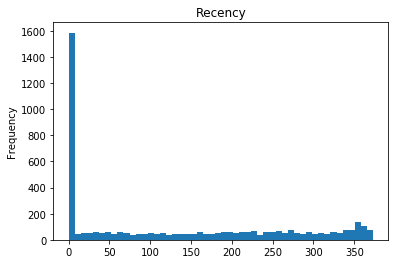

In [29]:
df['recency'].plot(kind='hist', bins=50)
plt.title('Recency')
print(df['recency'].describe())
print(sum(df['recency'] == 0)/float(len(data)))

Among all customers in our data, more than 35% of them only made purchase once (no repeat).
## Frequency/Recency Analysis Using the BG/NBD Model

In [30]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(df['frequency'], df['recency'], df['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


In [31]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


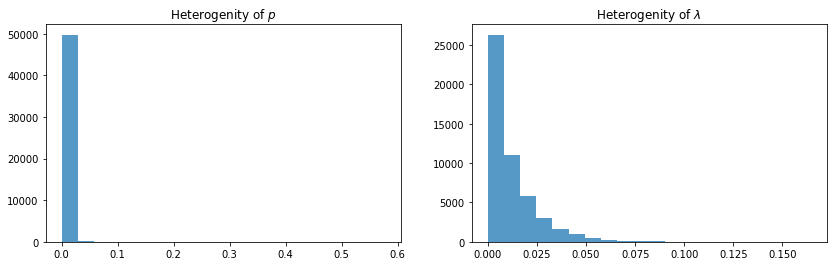

In [32]:
from scipy.stats import gamma, beta
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(df['frequency'], df['recency'], df['T'], )
print (bgf)
#  
# Plot
gbd = beta.rvs(bgf.params_['a'], bgf.params_['b'], size = 50000)
ggd = gamma.rvs(bgf.params_['r'], scale=1./bgf.params_['alpha'], size = 50000)
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title('Heterogenity of $p$')
temp = plt.hist(gbd, 20,  alpha=0.75)
plt.subplot(122) 
plt.title('Heterogenity of $\lambda$')
temp = plt.hist(ggd, 20,  alpha=0.75)

### Visualizing our frequency/recency matrix
Let's do some hypothetical analysis-
- Customer who purchased every day for four weeks straight, and no transactions in months; chances of that customer being alive is less. 
- On the other hand, a customer who historically made purchase once a quarter, and again last quarter, is likely still alive. We can visualize this relationship using the frequency/recency matrix, which computes the expected number of transactions an artificial customer is to make in the next time period, given the recency (age at last purchase) and frequency (the number of repeat transactions  made).

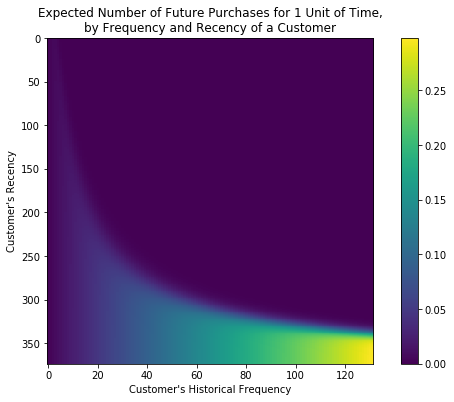

In [34]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(bgf)
plt.show()

We can see that, if a customer has made 120 purchases, and their latest purchase was when they were approximately 350 days old (i.e. Recency: the duration between their first transaction and their latest transaction is 350 days), then they are our best customer (bottom-right).

Customers who have purchased a lot and purchased recently will likely be the best customers in the future. We will never have enough of them.

Customers who have purchased a lot but not recently (top-right corner), have probably gone.
There are also another type of customers that around (40, 100) that represents the customer who buys infrequently, and we have not seen them recently, so they might buy again. However, we are not sure if they have gone or just between purchases.

Another interesting matrix to look at is the probability of still being alive:


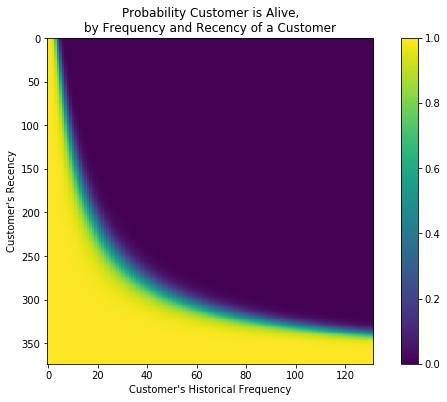

In [35]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(10,6))
plot_probability_alive_matrix(bgf)
plt.show()

- Customers who have purchased recently are almost surely “alive”.
- Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out. They are represented in the upper-right.

### Ranking customers from best to worst
Let’s return to our customers and rank them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.


In [36]:
t = 1
df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df['frequency'], df['recency'], df['T'])
df.sort_values(by='predicted_purchases').tail(10)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
16422.0,47.0,352.0,369.0,702.472340,0.109172
13798.0,52.0,371.0,372.0,706.650962,0.119809
14527.0,53.0,367.0,369.0,155.016415,0.122912
13089.0,65.0,367.0,369.0,893.714308,0.150316
12971.0,70.0,369.0,372.0,159.211286,0.160632
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581


Listed above are our top 10 customers that the model expects them to make purchases in the next day. We can see that the customer who has made 131 purchases, and bought very recently from us, is probably going to buy again in the next period.


The predicted_purchases column represents their expected number of purchases while the other three columns represent their current RF metrics. The BG/NBD model believes these individuals will be making more purchases within the near future as they are our current best customers.
#### Assessing model fit
So far, we can predict and we can visualize our customers’ behavior. Now let us assess the model’s correctness. The ﬁrst is to compare your data versus artiﬁcial data simulated with our ﬁtted model’s parameters.


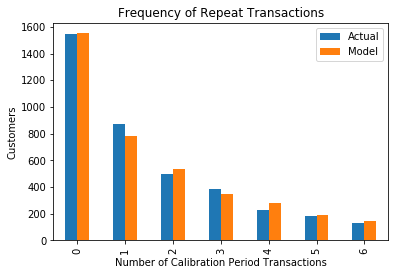

In [37]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)
plt.show()

Not bad, We can see that our actual data and our simulated data line up well. 
So, we can continue on with our analysis. We now partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (just like cross-validation in machine learning practice).

### Example using transactional datasets
Most often, the dataset you have at hand will be at the transaction level. Lifetimes has some utility functions to transform that transactional data (one row per purchase) into summary data (a frequency, recency and age dataset).

In [38]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


In [42]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')
print(summary.head())

    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


In [40]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

### More model fitting
With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature).

In [67]:
from lifetimes.utils import calibration_and_holdout_data
pd.get_option("display.max_columns")
summary_cal_holdout = calibration_and_holdout_data(data, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )
print(summary_cal_holdout.head())


            frequency_cal  recency_cal  ...  frequency_holdout  duration_holdout
CustomerID                              ...                                     
12346.0               0.0          0.0  ...                0.0               184
12347.0               2.0        121.0  ...                4.0               184
12348.0               2.0        110.0  ...                1.0               184
12350.0               0.0          0.0  ...                0.0               184
12352.0               3.0         34.0  ...                3.0               184

[5 rows x 5 columns]


With this dataset, we can perform ﬁtting on the _cal columns, and test on the _holdout columns:


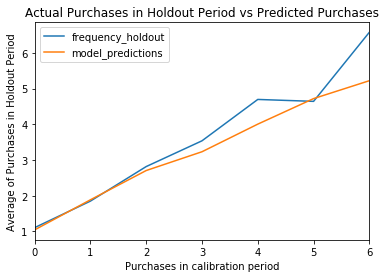

In [49]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
plt.show()

In this plot, we separate the data into both a in-sample (calibration) and validation (holdout) period. The sample period consists the beginning to 2011–06–08; the validation period spans from 2011–06–09 to 2011–12–09. The plot groups all customers in the calibration period by their number of repeat purchases (x-axis) and then averages over their repeat purchases in the holdout period (y-axis). The orange and blue line presents the model prediction and actual result of the y-axis respectively. As we can see, our model is able to predict the customer base’s behaviour out of the sample, the model under-estimates at 4 purchases and after 5 purchases.
### Customer transactions predictions
Based on customer history, we can now predict what an individual’s future purchases might look like:

In [52]:
t = 10 #predict purchases in 10 periods 
individual = df.loc[12347]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_, to_time` 
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.15727742663038222

Our model predicts that customer 12347’s future transaction is 0.157 in 10 days.
#### Customer probability histories

Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. For example, we want to look at our best customer’s transactions history and see the probability of being alive:

In [55]:
t = 1
df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df['frequency'], df['recency'], df['T'])
best_projected_cust = df.sort_values('predicted_purchases').tail(6)
df.sort_values(by='predicted_purchases').tail(6)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12971.0,70.0,369.0,372.0,159.211286,0.163087
14606.0,88.0,372.0,373.0,135.890114,0.204112
15311.0,89.0,373.0,373.0,677.729438,0.206412
17841.0,111.0,372.0,373.0,364.452162,0.257012
12748.0,113.0,373.0,373.0,298.360885,0.261612
14911.0,131.0,372.0,373.0,1093.661679,0.303013


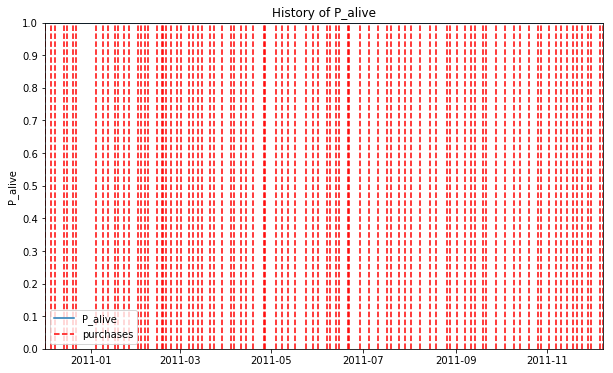

In [62]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
id = 14606
days_since_birth = 365
sp_trans = data.loc[data['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')
plt.show()

As per this plot, our best customer is not alive. On the other hand, this customer had only purchased once and has dropped off for a long time with a 100% chance that he is dead.
## Estimating customer lifetime value using gamma-gamma model of monetary value
So far, we didn’t take into account the economic value of each transaction and we focused mainly on transactions’ occurrences. To estimate this we can use the Gamma-Gamma submodel. But ﬁrst we need to create summary data from transactional data also containing economic values for each transaction (i.e. proﬁts or revenues). We are only estimating the customers who had at least one repeat purchase with us. Therefore, we are estimating for 2,790 customers.

In [68]:
returning_customers_summary = df[df['frequency']>0]
print(returning_customers_summary.head())
print()
print('\nCustomers with 1 repeat purchase\n', len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.015728
12348.0           3.0    283.0  358.0      301.480000             0.008918
12352.0           6.0    260.0  296.0      368.256667             0.018849
12356.0           2.0    303.0  325.0      269.905000             0.007094
12358.0           1.0    149.0  150.0      683.200000             0.008234


Customers with 1 repeat purchase
 2790


### The Gamma-Gamma model and the independence assumption
The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [69]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [70]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. 

In [71]:
print(ggf.conditional_expected_average_profit(
        df['frequency'],
        df['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64


In [72]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        df['frequency'],
        df['monetary_value']
    ).mean(),
    df[df['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 441.1284032747248, Average profit: 477.3586892535673


While for computing the total CLV using the DCF method (https://en.wikipedia.org/wiki/Discounted_cash_ﬂow) adjusting for cost of capital:


In [73]:
# refit the BG model to the summary_with_money_value dataset 
bgf.fit(df['frequency'], df['recency'], df['T'])
print(ggf.customer_lifetime_value( 
    bgf, #the model to use to predict the number of future transactions 
    df['frequency'], 
    df['recency'], 
    df['T'], 
    df['monetary_value'], time=12, # months 
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually 
).head(10)) 

CustomerID
12346.0     295.248495
12347.0    3010.933997
12348.0    1008.692677
12349.0    1337.106427
12350.0     306.932977
12352.0    2372.739690
12353.0     426.098903
12354.0     386.464312
12355.0     411.043379
12356.0     784.161526
Name: clv, dtype: float64


## Saving and loading model
When we have  lots of data and training takes a lot of time option with saving and loading model could be useful. First we need to ﬁt the model, then save it and load.

### Fit model



In [75]:
from lifetimes import BetaGeoFitter 
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0]) 
bgf = BetaGeoFitter() 
bgf.fit(df['frequency'], df['recency'], df['T']) 
bgf 

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>

### Saving model
Model will be saved with dill to pickle object. Optional parameters save_data and save_generate_data_method are present to reduce ﬁnal pickle object size for big dataframes. Optional parameters: 
- save_data is used for saving data from model or not (default: True). 
- save_generate_data_method is used for saving generate_new_data method from model or not (default: True)


In [0]:
bgf.save_model('bgf.pkl')


### Loading model
Before loading we should initialize the model ﬁrst and then use method load_model


In [77]:
bgf_loaded = BetaGeoFitter() 
bgf_loaded.load_model('bgf.pkl') 
bgf_loaded 

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>